# Predicting Covid-19 Test Results

The purpose of this notebook is develop a classifier to predict Covid-19 test results. The work will use the same data as the study below, using the same dates for training and testing subsets.

I will follow my own methods for training and validating the model and I will compare my results.

   - Zoabi, Y., Deri-Rozov, S. & Shomron, N. Machine learning-based prediction of COVID-19 diagnosis based on symptoms. npj Digit. Med. 4, 3 (2021). https://doi.org/10.1038/s41746-020-00372-6


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

seed = 2019

## Data

In [2]:
covid = pd.read_csv('corona_tested_individuals_ver_006.english.csv',
                    low_memory=False)
covid

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other
3,2020-04-30,1,0,0,0,0,negative,None,female,Other
4,2020-04-30,1,0,0,0,0,negative,None,male,Other
...,...,...,...,...,...,...,...,...,...,...
278843,2020-03-11,0,0,0,0,0,negative,None,None,Other
278844,2020-03-11,0,0,0,0,0,negative,None,None,Other
278845,2020-03-11,0,0,0,0,0,positive,None,None,Contact with confirmed
278846,2020-03-11,0,0,0,0,0,other,None,None,Other


In the original study, training data was from March 22nd to March 31st. Testing data was April 1st to April 7th.

In [3]:
# making the test_date column only month and day
covid.test_date = covid.test_date.apply(lambda x: x.replace('-', '')[-4:]).astype('int32')
# getting only the desired dates from the study
covid = covid[(covid.test_date>321) & (covid.test_date<408)]

## Data Exploration

In [4]:
# missing values - no
covid.isnull().any()

test_date              False
cough                  False
fever                  False
sore_throat            False
shortness_of_breath    False
head_ache              False
corona_result          False
age_60_and_above       False
gender                 False
test_indication        False
dtype: bool

### Value counts for categorical features:

In [5]:
# data types
covid.dtypes

test_date               int32
cough                  object
fever                  object
sore_throat            object
shortness_of_breath    object
head_ache              object
corona_result          object
age_60_and_above       object
gender                 object
test_indication        object
dtype: object

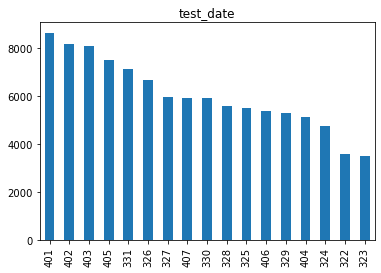

401    8654
402    8188
403    8079
405    7509
331    7134
326    6663
327    5963
407    5931
330    5915
328    5602
325    5495
406    5368
329    5277
404    5145
324    4735
322    3565
323    3494
Name: test_date, dtype: int64



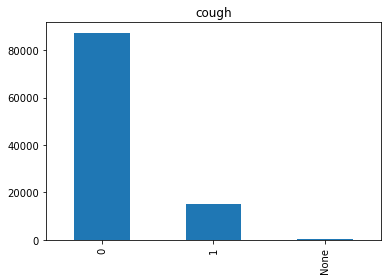

0       87339
1       15137
None      241
Name: cough, dtype: int64



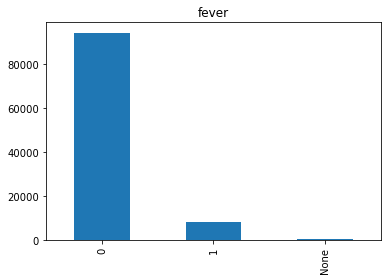

0       94169
1        8306
None      242
Name: fever, dtype: int64



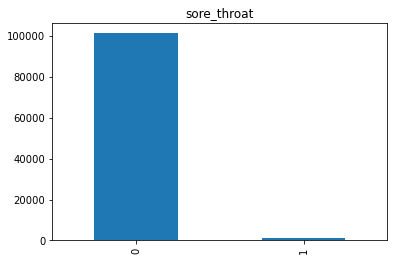

0    101378
1      1339
Name: sore_throat, dtype: int64



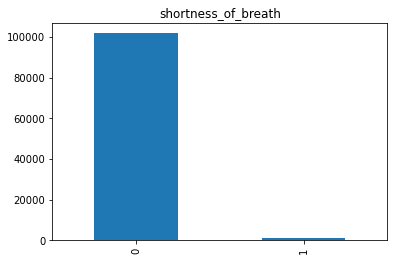

0    101731
1       986
Name: shortness_of_breath, dtype: int64



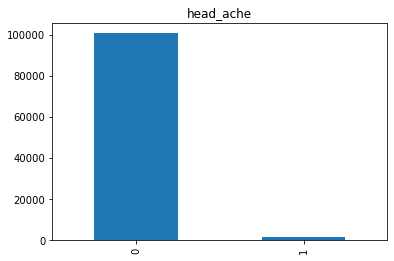

0    100828
1      1889
Name: head_ache, dtype: int64



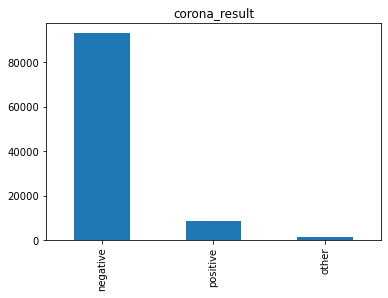

negative    93046
positive     8436
other        1235
Name: corona_result, dtype: int64



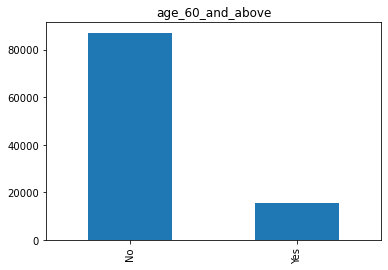

No     87067
Yes    15650
Name: age_60_and_above, dtype: int64



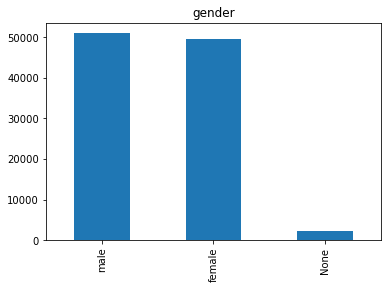

male      50983
female    49472
None       2262
Name: gender, dtype: int64



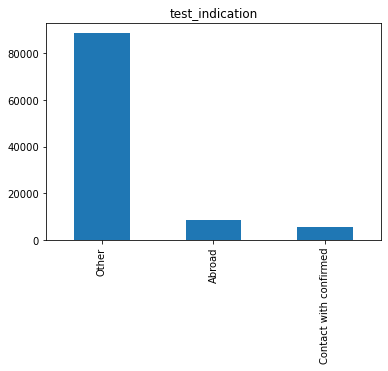

Other                     88663
Abroad                     8435
Contact with confirmed     5619
Name: test_indication, dtype: int64



In [6]:
for col in covid.columns:
    covid[col].value_counts(dropna=False).plot(kind="bar", title = f'{col}');
    plt.show()
    print(covid[col].value_counts(dropna=False))
    print()

## Processing

Three possible processing pipelines
   1. Drop missing values --> one-hot encode categorical features
   2. Impute missing values --> one-hot encode categorical features
   3. Leave missing values to be handled by GradientBoost --> map categorical features to numbers for GradientBoost
   
Best results were with preprocessing 1.

In [7]:
# PROCESSING 1

# dropping all rows with "None"
covid = covid.replace('None', np.nan).dropna()

#fixing weird integers
covid = covid.astype({'sore_throat':'int32',
                      'shortness_of_breath':'int32',
                      'head_ache':'int32'})

# dropping 'other' as a test result category
# now our target will either be positive or negative
covid = covid[covid.corona_result != 'other']

# one-hot encoding the rest 
covid = pd.get_dummies(data=covid, 
                       columns=["corona_result","age_60_and_above","gender","test_indication"], 
                       drop_first = True)

covid.rename(columns={"corona_result_positive": "corona_result"}, inplace = True)
# covid

In [8]:
# PROCESSING 2: IMPUTING MISSING VALUES
n = 'no'
if n == 'yes':
    # imputing missing values with majority value
    covid = covid.replace('None', np.nan)
    covid.cough = covid.cough.fillna(0)
    covid.fever = covid.fever.fillna(0)
    covid.gender = covid.gender.fillna('male')


    #fixing weird integers
    covid = covid.astype({'cough':'int32',
                          'fever':'int32',
                          'sore_throat':'int32',
                          'shortness_of_breath':'int32',
                          'head_ache':'int32'})

    # dropping 'other' as a test result category
    # now our target will either be positive or negative
    covid = covid[covid.corona_result != 'other']

    # one-hot encoding the rest 
    covid = pd.get_dummies(data=covid, 
                           columns=["corona_result","age_60_and_above","gender","test_indication"], 
                           drop_first = True)

    covid.rename(columns={"corona_result_positive": "corona_result"}, inplace = True)

In [9]:
# PROCESSING 3: FOR GRADIENT BOOST

n = 'no'
if n == 'yes':
    covid = covid.replace('None', np.nan)

    #fixing weird integers
    covid = covid.astype({'sore_throat':'int32',
                          'shortness_of_breath':'int32',
                          'head_ache':'int32'})

    # dropping 'other' as a test result category
    # now our target will either be positive or negative
    covid = covid[covid.corona_result != 'other']

    # mapping categorical data to integers for gradient boost
    covid.corona_result = covid.corona_result.map({'negative':0,'positive':1})
    covid.age_60_and_above = covid.age_60_and_above.map({'No':0, 'yes':1},na_action='ignore')
    covid.gender = covid.gender.map({'female':0,'male':1}, na_action='ignore')
    covid.test_indication = covid.test_indication.map({'Other':0,'Contact with confirmed':1,'Abroad':2})

### Train / Test Split
   - Based on dates defined in the original study

In [10]:
train = covid[covid.test_date<401]
print("train", train.shape[0])
test = covid[covid.test_date>=401]
print("test ", test.shape[0])

train 51814
test  47175


## Resampling

Because there are so few positive results compared to the negative results, the target is very unbalanced. In order to train better, I will resample the train/validate set so that there are equal numbers of positive and negative results.

Specifically, I will *upsample* the positive results. That is to say, I will randomly duplicate positive rows until there are as many positive training examples as there are negative ones.

In [11]:
# how bad is the imbalance?
train.corona_result.value_counts()

0    47054
1     4760
Name: corona_result, dtype: int64

In [12]:
# resampling the rows of the dataset with positive test results to end up with the same number of
# rows as the negative test results
# pos_upsampled is all columns but ONLY FOR POSITIVE TEST results
from sklearn.utils import resample

pos_upsampled = resample(train[train.corona_result==1],
                             replace=True, 
                             n_samples = train[train.corona_result== 0].shape[0],
                             random_state=seed)

pos_upsampled.corona_result.value_counts()

1    47054
Name: corona_result, dtype: int64

In [13]:
# the covid dataset with only the negative test results
neg = train[train.corona_result==0]
neg.corona_result.value_counts()

0    47054
Name: corona_result, dtype: int64

In [14]:
# balanced covid dataset of the two put back together
bal_train = pd.concat([neg,pos_upsampled])
# display(bal_train.head())
display(bal_train.corona_result.value_counts())

0    47054
1    47054
Name: corona_result, dtype: int64

Now I'll define the final training and testing data sets, split into features (X) and target (y):

In [15]:
# training data: March 22nd to March 31st, upsampled positive rows
X_train = bal_train.drop(columns=['corona_result', 'test_date']).values
y_train = bal_train.corona_result.values

# testing data: April 1st to April 7th, no resampling
X_test = test.drop(columns=['corona_result', 'test_date']).values
y_test = test.corona_result.values

## Model Selection

Here I tune hyperparameters on different classifiers.

In [16]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

sgd = SGDClassifier(random_state=seed)

param_grid = {
        'alpha': [.01,.001, .0001, .00001],
        'penalty': ['l1', 'l2'],
        'learning_rate': ["adaptive", "optimal"],
        'eta0': [.0001,.001,.01]   
}
# Set up search
searchSGD = GridSearchCV(estimator=sgd,
                  param_grid=param_grid,
                  scoring='roc_auc',
                  cv=10,
                  n_jobs=2)
# Run search
searchSGD = searchSGD.fit(X_train, y_train)
# output search results
print(searchSGD.best_score_)
print(searchSGD.best_params_)

0.9369088653141919
{'alpha': 0.001, 'eta0': 0.001, 'learning_rate': 'adaptive', 'penalty': 'l2'}
CPU times: user 18.6 s, sys: 2.2 s, total: 20.8 s
Wall time: 2min 15s


In [17]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=seed)

param_grid = {
        'n_estimators': [10, 100, 1000],
        'max_depth': [2,4,6,10,25], 
}
# Set up search
searchrf = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='roc_auc',
                  cv=10,
                  n_jobs=2)
# Run search
searchrf = searchrf.fit(X_train, y_train)
# output search results
print(searchrf.best_score_)
print(searchrf.best_params_)

0.9516894090350725
{'max_depth': 10, 'n_estimators': 100}
CPU times: user 7.06 s, sys: 766 ms, total: 7.82 s
Wall time: 12min 11s


In [18]:
%%time

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier(activation='relu',
                    solver='adam',
                    max_iter=400,
                    random_state=seed)

param_grid = {
        'alpha': [.0001],
        'learning_rate': ["adaptive", "constant"],
        'learning_rate_init':[.001,.01],
        'hidden_layer_sizes' : [(9,),(27,),(9,9),(9,9,6),(9,9,6,6)]
}
# Set up search
searchMLP = GridSearchCV(estimator=mlp,
                  param_grid=param_grid,
                  scoring='roc_auc',
                  cv=10,
                  n_jobs=2)
# Run search
searchMLP = searchMLP.fit(X_train, y_train)
# output search results
print(searchMLP.best_score_)
print(searchMLP.best_params_)

0.9519038257055632
{'alpha': 0.0001, 'hidden_layer_sizes': (9, 9, 6, 6), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}
CPU times: user 22.6 s, sys: 1.32 s, total: 23.9 s
Wall time: 18min 49s


In [19]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb = HistGradientBoostingClassifier(categorical_features=[0,1,2,3,4,5,6,7,8], random_state=seed)

param_grid = {
        'learning_rate': [.05, .1,],
        'max_leaf_nodes': [None,31,50],
        'scoring':['loss'],
        'min_samples_leaf':[4, 20]
}
# Set up search
searchgb = GridSearchCV(estimator=gb,
                  param_grid=param_grid,
                  scoring='roc_auc',
                  cv=10,
                  n_jobs=2)
# Run search
searchgb = searchgb.fit(X_train, y_train)
# output search results
print(searchgb.best_score_)
print(searchgb.best_params_)

0.9519515295442158
{'learning_rate': 0.05, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'scoring': 'loss'}
CPU times: user 10.9 s, sys: 570 ms, total: 11.5 s
Wall time: 3min 19s


## Model Evaluation

Using the optimal hyperparameters found in model selection, I predict on the test data set.

Then I output the classification report, confusion matrix, and ROC_AUC score for each classifier.

ROC_AUC (Receiver operating characteristic area under the curve) is the evaluation measure because the target values are unbalanced in the test set. That is, there are very many more negative results than positive results in the test set.  

In [20]:
#imports
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report as report

### SGD Evaluation

Classification Report for SGD Classifier
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     43570
           1       0.51      0.77      0.62      3605

    accuracy                           0.93     47175
   macro avg       0.75      0.86      0.79     47175
weighted avg       0.94      0.93      0.93     47175

SGD ROC AUC score:  0.856



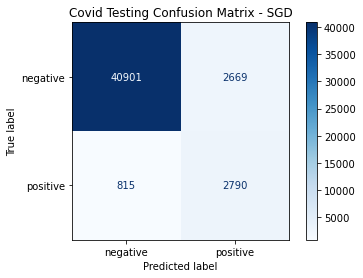

In [21]:
sgd_pred = searchSGD.predict(X_test)
print("Classification Report for SGD Classifier")
print(report(y_test,sgd_pred))
print("SGD ROC AUC score: ", round(roc_auc_score(y_test, sgd_pred), 3))
print()

title = "Covid Testing Confusion Matrix - SGD"
class_names = ['negative','positive']
# print(title)
disp = ConfusionMatrixDisplay.from_predictions(y_test, sgd_pred,
                                                 display_labels=class_names,
                                                 cmap=plt.cm.Blues)
disp.ax_.set_title(title);
plt.show()

### Random Forest Evaluation

Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     43570
           1       0.40      0.84      0.55      3605

    accuracy                           0.89     47175
   macro avg       0.69      0.87      0.74     47175
weighted avg       0.94      0.89      0.91     47175

Random Forest ROC AUC score:  0.867



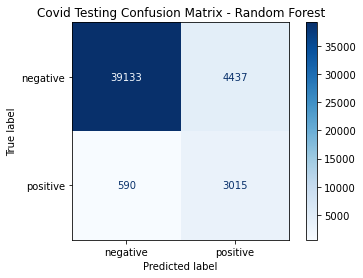

In [22]:
rf_pred = searchrf.predict(X_test)
print("Classification Report for Random Forest")
print(report(y_test,rf_pred))
print("Random Forest ROC AUC score: ", round(roc_auc_score(y_test, rf_pred), 3))
print()

title = "Covid Testing Confusion Matrix - Random Forest"
class_names = ['negative','positive']
# print(title)
disp = ConfusionMatrixDisplay.from_predictions(y_test, rf_pred,
                                                 display_labels=class_names,
                                                 cmap=plt.cm.Blues)
disp.ax_.set_title(title);
plt.show()

### MLP Evaluation

Classification Report for MLP Classifier
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     43570
           1       0.40      0.84      0.54      3605

    accuracy                           0.89     47175
   macro avg       0.69      0.87      0.74     47175
weighted avg       0.94      0.89      0.91     47175

MLP ROC AUC score:  0.868



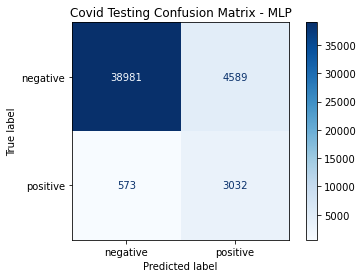

In [23]:
mlp_pred = searchMLP.predict(X_test)
print("Classification Report for MLP Classifier")
print(report(y_test,mlp_pred))
print("MLP ROC AUC score: ", round(roc_auc_score(y_test, mlp_pred), 3))
print()

title = "Covid Testing Confusion Matrix - MLP"
class_names = ['negative','positive']
# print(title)
disp = ConfusionMatrixDisplay.from_predictions(y_test, mlp_pred,
                                                 display_labels=class_names,
                                                 cmap=plt.cm.Blues)
disp.ax_.set_title(title);
plt.show()

### Gradient Boosting Evaluation

Classification Report for GB Classifier
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     43570
           1       0.40      0.84      0.54      3605

    accuracy                           0.89     47175
   macro avg       0.69      0.87      0.74     47175
weighted avg       0.94      0.89      0.91     47175

Gradient Boosting ROC AUC score:  0.868



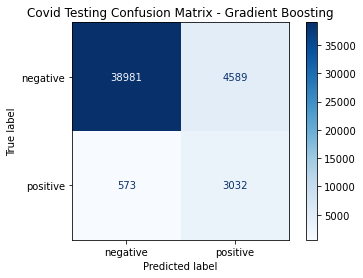

In [24]:
gb_pred = searchgb.predict(X_test)
print("Classification Report for GB Classifier")
print(report(y_test,gb_pred))
print("Gradient Boosting ROC AUC score: ", round(roc_auc_score(y_test, gb_pred), 3))
print()

title = "Covid Testing Confusion Matrix - Gradient Boosting"
class_names = ['negative','positive']
# print(title)
disp = ConfusionMatrixDisplay.from_predictions(y_test, gb_pred,
                                                 display_labels=class_names,
                                                 cmap=plt.cm.Blues)
disp.ax_.set_title(title);
plt.show()

## Evaluation

The original study finished with an ROC_AUC of .90.

My best results, with both the Multilayer Perceptron and the HistGradientBoost were ROC_AUC of .868.